In [49]:
import requests
import json
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import itertools
from itertools import product
import random
import seaborn as sns
from scipy.stats import bernoulli

In [2]:
df = pd.read_csv('../data/spotify_dataset.csv', usecols=range(4), lineterminator='\n', header=0)

In [3]:
df.columns = [x.replace('"', '').lstrip() for x in df.columns]

In [4]:
playlists = df['playlistname'].unique()
print('Number of Playlists:', len(playlists))
print('Number of Artists:', len(df['artistname'].unique()))

Number of Playlists: 161530
Number of Artists: 290002


#### Problem:
- Networkx takes too much time to load up a graph with all the data <br>
- In ~5 min we can retrieve 2000 artist genres


#### Potential Solution:
- Sample 1,000 playlists
- See if there is a sufficient amount of artists and playlist appearances

In [5]:
np.random.seed(0)
sample_playlists = np.random.choice(playlists, 2000, replace=False)
sampled_df = df[df['playlistname'].isin(sample_playlists)]

In [6]:
print('Number of songs in sample:', len(sampled_df))
print('Number of Artists:', len(sampled_df['artistname'].unique()))

Number of songs in sample: 126537
Number of Artists: 18139


In [7]:
appearances = sampled_df.groupby('artistname').agg({'trackname':'count', 'playlistname':lambda x: len(x.unique())})
appearances.sort_values(by=['trackname', 'playlistname'])

,trackname,playlistname
artistname,,
!!!,1,1
!Tang,1,1
(LinSMHPAS),1,1
(hed) pe/Kottonmouth Kings/Tech N9ne,1,1
009 Sound System,1,1
...,...,...
Tony Bennett,567,8
Marvin Gaye,599,35
The xx,631,41


- There are some artists that appear on an insignificant amount of playlists, define this to be anything less than 10

In [8]:
artists = appearances[appearances['playlistname']>=10].index
print('# of artists on >= 10 playlists (sample):', len(artists))

# of artists on >= 10 playlists (sample): 623


In [9]:
df1 = sampled_df[sampled_df['artistname'].isin(artists)]
df1

,user_id,artistname,trackname,playlistname
1898,944c80d26922ae634d6ce445b1fdff7f,Kelly Clarkson,Because of You,JOOTDR
1903,944c80d26922ae634d6ce445b1fdff7f,Coldplay,Fix You,JOOTDR
1904,944c80d26922ae634d6ce445b1fdff7f,Passenger,Golden Thread (feat. Matt Corby),JOOTDR
1910,944c80d26922ae634d6ce445b1fdff7f,Lady Antebellum,Need You Now,JOOTDR
1914,944c80d26922ae634d6ce445b1fdff7f,A Great Big World,Say Something,JOOTDR
...,...,...,...,...
12880427,dd9be94cb1c51cea277c3814c6f9a185,deadmau5,Strobe - Michael Woods 2014 Remix,deadmau5 — 5 years of mau5
12880428,dd9be94cb1c51cea277c3814c6f9a185,deadmau5,The Veldt (deadmau5 Vs. Eric Prydz Edit),deadmau5 — 5 years of mau5
12880429,dd9be94cb1c51cea277c3814c6f9a185,deadmau5,The Veldt - 8 Minute Edit,deadmau5 — 5 years of mau5
12881104,43cc50ed2f95d8eeedac31e3b919bf5c,Ryan Adams,Wonderwall,turtles all the way down


- Only take playlists that have more than 1 artist (otherwise there's no edge)

In [10]:
df1_grped = df1.groupby('playlistname').agg({'artistname':lambda x: len(x.unique())})
playlists = df1_grped[df1_grped['artistname'] > 1].index

In [11]:
df2 = df1[df1['playlistname'].isin(playlists)]
df2

,user_id,artistname,trackname,playlistname
1898,944c80d26922ae634d6ce445b1fdff7f,Kelly Clarkson,Because of You,JOOTDR
1903,944c80d26922ae634d6ce445b1fdff7f,Coldplay,Fix You,JOOTDR
1904,944c80d26922ae634d6ce445b1fdff7f,Passenger,Golden Thread (feat. Matt Corby),JOOTDR
1910,944c80d26922ae634d6ce445b1fdff7f,Lady Antebellum,Need You Now,JOOTDR
1914,944c80d26922ae634d6ce445b1fdff7f,A Great Big World,Say Something,JOOTDR
...,...,...,...,...
12880385,dd9be94cb1c51cea277c3814c6f9a185,Tiësto,Paradise,"Tiësto - Club Life, Vol. 3"
12880386,dd9be94cb1c51cea277c3814c6f9a185,Tiësto,Shocker,"Tiësto - Club Life, Vol. 3"
12880387,dd9be94cb1c51cea277c3814c6f9a185,Tiësto,Take Me,"Tiësto - Club Life, Vol. 3"
12880388,dd9be94cb1c51cea277c3814c6f9a185,Dimitri Vegas,Turn It Up,"Tiësto - Club Life, Vol. 3"


In [12]:
unq_play = sampled_df.groupby(['artistname', 'playlistname']).count().reset_index().groupby('artistname').count()[['playlistname']].reset_index()
# unq_play = unq_play.groupby('playlistname').count()
unq_play


,artistname,playlistname
0,!!!,1
1,!Tang,1
2,#1 Katy Perry Tribute Band,1
3,(Hed) P.E.,1
4,(LinSMHPAS),1
...,...,...
18133,童安格,1
18134,衛蘭,1
18135,袁惟仁,1
18136,費玉清,1


[Text(0.5, 0, 'frequency'), Text(0.5, 1.0, 'Top 10 artist frequencies')]

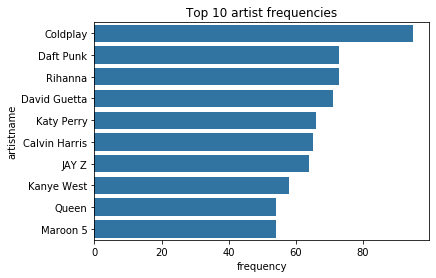

In [13]:
top_10 = unq_play.sort_values(by = 'playlistname', ascending = False)[:10]
f, ax = plt.subplots()
sns.set_color_codes("pastel")
sns.barplot(y="artistname", x="playlistname", data=top_10, orient = 'h', color = '#1f77b4')
ax.set(xlabel = 'frequency', title = 'Top 10 artist frequencies')

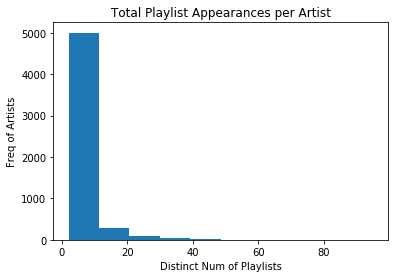

In [14]:
plt.hist(unq_play[(unq_play['playlistname'] > 1)]['playlistname'], bins=10)
plt.xlabel('Distinct Num of Playlists')
plt.ylabel('Freq of Artists')
plt.title('Total Playlist Appearances per Artist')
plt.savefig('playlistapp')

In [15]:
# same def as quarter 1
def read_edge(gph, n0, n1):
    if gph.has_edge(n0, n1):
        gph[n0][n1]['weight'] +=1
        return gph[n0][n1]['weight']
    else:
        gph.add_edge(n0, n1, weight=1)
        return 1

In [16]:
%%time
G = nx.Graph()
# if not unique, could weight the number of times the artist appears in that playlist
df2_grp = df2.groupby('playlistname').agg({'artistname': lambda x: (x).unique()})

for i in range(len(df2_grp)):
    
    for a in (df2_grp.iloc[i]):
        for a1, a2 in itertools.combinations(a, 2):
            read_edge(G, a1, a2)


CPU times: user 748 ms, sys: 18.7 ms, total: 766 ms
Wall time: 770 ms


In [17]:
# threshold = 1
# long_edges = list(filter(lambda e: e[2] <= threshold, (e for e in G.edges.data('weight'))))
# G.remove_edges_from(long_edges)

CPU times: user 6.43 s, sys: 138 ms, total: 6.57 s
Wall time: 6.42 s


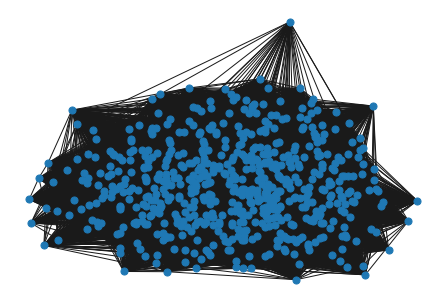

In [18]:
%%time
nx.draw(G, node_size=50)


In [19]:
# # [n for n in G.neighbors]
# neighbors = []
# for i in G.nodes:
#     count = 0
#     for k in G.neighbors(i):
#         count += 1
#     neighbors.append(count)
# neigh_df = pd.DataFrame(G.nodes)
# neigh_df['neighbors'] = neighbors
# neigh_df
# plt.hist(neigh_df['neighbors'])
# plt.xlabel('Number of Neighbors')
# plt.ylabel('Node Count')
# plt.title('Node Freq of Neighbor Count')
# plt.savefig('node_freq')

In [20]:
weight_dict = {}
node_weights = nx.get_edge_attributes(G, "weight")
for i in node_weights:
    if 'Justin Timberlake' in i:
        weight_dict[i] = node_weights[i]

In [21]:
sorted(weight_dict.items(), key=lambda x:x[1], reverse=True)

[(('JAY Z', 'Justin Timberlake'), 24),
 (('Beyoncé', 'Justin Timberlake'), 20),
 (('Rihanna', 'Justin Timberlake'), 20),
 (('Katy Perry', 'Justin Timberlake'), 19),
 (('Daft Punk', 'Justin Timberlake'), 18),
 (('Usher', 'Justin Timberlake'), 17),
 (('Kanye West', 'Justin Timberlake'), 17),
 (('Coldplay', 'Justin Timberlake'), 15),
 (('Maroon 5', 'Justin Timberlake'), 15),
 (('Justin Timberlake', 'Britney Spears'), 15),
 (('P!nk', 'Justin Timberlake'), 14),
 (('Ellie Goulding', 'Justin Timberlake'), 14),
 (('Fun.', 'Justin Timberlake'), 14),
 (('Bruno Mars', 'Justin Timberlake'), 14),
 (('Lorde', 'Justin Timberlake'), 14),
 (('Justin Timberlake', 'Eminem'), 14),
 (('Justin Timberlake', 'Michael Jackson'), 14),
 (('Justin Timberlake', 'Imagine Dragons'), 14),
 (('Justin Timberlake', 'Chris Brown'), 14),
 (('Calvin Harris', 'Justin Timberlake'), 13),
 (('David Guetta', 'Justin Timberlake'), 13),
 (('Drake', 'Justin Timberlake'), 13),
 (('Pitbull', 'Justin Timberlake'), 13),
 (('Justin Tim

In [22]:
len(G.nodes)

623

In [23]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

def get_artist_genres(artist_names):
    client_id = '8ac5bd4f29854a4abb37648a5b7833d8'
    client_secret = 'c9f1281a0f774d97ae7d002139e53049'
    client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

    artist_dict = {}
    
    for artist in artist_names:
        result = sp.search(artist, type='artist')['artists']['items']
        if len(result) > 0:
            artist_dict[artist] = result[0]['genres']
    return artist_dict


In [24]:
genres = get_artist_genres(list(G.nodes))

In [25]:
df2[df2['artistname']=='Phoenix']

,user_id,artistname,trackname,playlistname
76060,6cdb890a9fff57be31b072777350e632,Phoenix,Rome,END OF SUMMER
85488,424678a7d04868568c9f95863a901d88,Phoenix,If I ever feel better,heartlifting
652352,a0d09df570e7f26128e94330d8f18916,Phoenix,1901,00's mega mix!!
652512,a0d09df570e7f26128e94330d8f18916,Phoenix,If I ever feel better,00's mega mix!!
652547,a0d09df570e7f26128e94330d8f18916,Phoenix,Long Distance Call,00's mega mix!!
...,...,...,...,...
12110394,efe2fd013382dab67cf26a45a2c51a81,Phoenix,1901,Run.
12327296,7076c43597ecefbc84aff169e32e8e94,Phoenix,Entertainment,Trabajando modo viernes
12327298,7076c43597ecefbc84aff169e32e8e94,Phoenix,If I ever feel better,Trabajando modo viernes
12847587,e6650a56a9c408231816d433da505557,Phoenix,1901,Trendy


In [26]:
# # matrix of (nodes, edgeweights)
# A = nx.to_numpy_array(G)

# # perform bigclam(cluster affiliation model) algorithm
# # F, ll = train(A, 3)

# # def train(A, C, iterations = 100):
#     # initialize an F
# C = 3
# iterations = 1
# N = A.shape[0] # number of nodes
# F = np.random.rand(N,C) # random (Nx3) matrix

# for n in range(iterations):
#     # iterate through all nodes 100 times
#     for person in range(N):
#         # calculate gradient
#         C = F.shape[1] # number of columns in F

#         neighbours = np.where(A[person]) # nodes
#         nneighbours = np.where(1-A[person]) # edges, weights

#         sum_neigh = np.zeros((C,)) # initialize a (1x3) matrix

#         for nb in neighbours[0]: # iterate through all neighbors
#             dotproduct = F[nb].dot(F[person]) # F values of curr neighbor by the curr node
#             # helper function sigm
#             sum_neigh += F[nb]*sigm(dotproduct) # calculation stored in the matrix
            
#         sum_nneigh = np.zeros((C,)) # initialize (1x3) matrix
#         #Speed up this computation using eq.4
#         for nnb in nneighbours[0]:
#             sum_nneigh += F[nnb]

#         grad = sum_neigh - sum_nneigh 
#         # end gradient calculation
        
#         F[person] += 0.005*grad

#         F[person] = np.maximum(0.001, F[person]) # F should be nonnegative

#     # log likelihood calc
#     A_soft = F.dot(F.T)

#     # Next two lines are multiplied with the adjacency matrix, A
#     # A is a {0,1} matrix, so we zero out all elements not contributing to the sum
#     FIRST_PART = A*np.log(1.-np.exp(-1.*A_soft))
#     sum_edges = np.sum(FIRST_PART)
#     SECOND_PART = (1-A)*A_soft
#     sum_nedges = np.sum(SECOND_PART)
#     ll = sum_edges - sum_nedges
#     print(ll)
    
# F, #log_likelihood(F, A)
# # end log likelihood count


In [27]:
# implement algorithm



In [28]:
## algorithm work

A = nx.to_numpy_array(G)

def sigm(x):
    return np.divide(np.exp(-1.*x),1.-np.exp(-1.*x))

def log_likelihood(F, A):
    """implements equation 2 of 
    https://cs.stanford.edu/people/jure/pubs/bigclam-wsdm13.pdf"""
    A_soft = F.dot(F.T)

    # Next two lines are multiplied with the adjacency matrix, A
    # A is a {0,1} matrix, so we zero out all elements not contributing to the sum
    FIRST_PART = A*np.log(1.-np.exp(-1.*A_soft))
    sum_edges = np.sum(FIRST_PART)
    SECOND_PART = (1-A)*A_soft
    sum_nedges = np.sum(SECOND_PART)

    log_likeli = sum_edges - sum_nedges
    return log_likeli

def gradient(F, A, i):
    """Implements equation 3 of
    https://cs.stanford.edu/people/jure/pubs/bigclam-wsdm13.pdf
    
      * i indicates the row under consideration
    
    The many forloops in this function can be optimized, but for
    educational purposes we write them out clearly
    """
    N, C = F.shape

    neighbours = np.where(A[i])
    nneighbours = np.where(1-A[i])

    sum_neigh = np.zeros((C,))
    for nb in neighbours[0]:
        dotproduct = F[nb].dot(F[i])
        sum_neigh += F[nb]*sigm(dotproduct)

    sum_nneigh = np.zeros((C,))
    #Speed up this computation using eq.4
    for nnb in nneighbours[0]:
        sum_nneigh += F[nnb]

    grad = sum_neigh - sum_nneigh
    return grad

def train(A, C, iterations = 100):
    # initialize an F
    N = A.shape[0]
    F = np.random.rand(N,C)

    for n in range(iterations):
        for person in range(N):
            grad = gradient(F, A, person)

            F[person] += 0.005*grad
    

            F[person] = np.maximum(0.001, F[person]) # F should be nonnegative
        ll = log_likelihood(F, A)
    return F, log_likelihood(F, A)


In [116]:
# perform bigclam algorithm
start = time.time()
F, ll = train(A, 3) # 3 is number of groups
pred = np.argmax(F, 1)
end = time.time()
print(end - start)

200.66311383247375


In [117]:


nodes = list(G.nodes())
# prediction groups
one = [nodes[i] for i in np.where(pred == 0)[0]]
two = [nodes[i] for i in np.where(pred == 1)[0]]
three = [nodes[i] for i in np.where(pred == 2)[0]]


In [118]:
# nodes

In [119]:
def pair_grp(nodes):
    grps = []
    for node in nodes:
        if node in one:
            grps.append(1)
        if node in two:
            grps.append(2)
        if node in three:
            grps.append(3)
    return grps


In [120]:
# calc percent of top edges are in the same group
dict_nodes_edg_grp = {}
for i in nodes:
    dict_nodes_edg_grp[i] = []
    weight_dict = {}
    node_weights = nx.get_edge_attributes(G, "weight")
    for j in node_weights:
        if i in j:
            weight_dict[j] = (node_weights[j], pair_grp(j))
    weight_dict = sorted(weight_dict.items(), key=lambda x:x[1], reverse=True)
    dict_nodes_edg_grp[i].append(weight_dict[:3])



In [124]:
grps_edg = []
for i in dict_nodes_edg_grp.values():
    # iterate through this node's largest edges
    for j in i[0]:
#         if j[1][1][0] == j[1][1][1]:
#             grps_edg.append(True)
#             break
        grps_edg.append(j[1][1])


In [126]:
# (623-len(grps_edg)) / 623

In [125]:
sum([x[0]==x[1] for x in grps_edg])/len(grps_edg)

0.43980738362760835

In [127]:
weight_dict = {}
node_weights = nx.get_edge_attributes(G, "weight")
for i in node_weights:
    if 'St. Vincent' in i:
        weight_dict[i] = (node_weights[i], pair_grp(i))
        

In [76]:
# sorted(weight_dict.items(), key=lambda x:x[1], reverse=True)

In [73]:
# Node attributes

In [94]:
df2
# avg songs per playlist
x = df2.groupby('artistname').agg({'playlistname':lambda x: len(np.unique(np.array(list(x)))), 'trackname':'count'})
x['trackname'] / x['playlistname']


artistname
2Pac                    1.473684
3 Doors Down            1.500000
50 Cent                 1.562500
A Great Big World       1.076923
A Tribe Called Quest    3.363636
                          ...   
a-ha                    1.600000
alt-J                   3.863636
blink-182               3.043478
deadmau5                2.444444
will.i.am               1.310345
Length: 623, dtype: float64

In [95]:
# total songs
x = df2.groupby('artistname').agg({'trackname':'count'})
x


,trackname
artistname,
2Pac,28
3 Doors Down,18
50 Cent,25
A Great Big World,14
A Tribe Called Quest,37
...,...
a-ha,16
alt-J,85
blink-182,70


In [108]:
# song variety - closer to 1: unique song on every playlist, closer to 0: many songs in common over playlists
x = df2.groupby('artistname').agg({'trackname':lambda x: len(np.unique(np.array(list(x)))), 'playlistname':'count'})
(x['trackname'] / x['playlistname']).sort_values()


artistname
Europe                  0.055556
Faul & Wad Ad           0.083333
Sheppard                0.083333
Starship                0.117647
Ariana Grande           0.128000
                          ...   
Leonard Cohen           1.000000
Sarah McLachlan         1.000000
The Beatles             1.000000
Antonio Vivaldi         1.000000
Ludwig van Beethoven    1.000000
Length: 623, dtype: float64

In [115]:
# playlist appearances
x = df2.groupby('artistname').agg({'playlistname':lambda x: len(np.unique(np.array(list(x))))})
x.sort_values(by='playlistname')


,playlistname
artistname,
Antonio Vivaldi,4
Wolfgang Amadeus Mozart,6
Nickelback,7
Extremoduro,7
Lady Antebellum,8
...,...
Katy Perry,66
David Guetta,68
Daft Punk,72


In [ ]:
x.mean() 
